In [1]:
import glob                # glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow as tf
import os
import re                  # 파이썬 정규표현식을 사용하기 위한 모듈
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 언어 모델(Language Model)
n−1개의 단어 시퀀스 w1,⋯,wn−1가 주어졌을 때, n번째 단어 wn으로 무엇이 올지를 예측하는 확률 모델
- 훈련/학습할 땐 
    - x_train : n-1번째까지 단어 시퀀스
    - y_train : n번째 단어
- 예측할 땐
    - x_test : n-1번째까지 단어 시퀀스
    - y_test : n번째 단어
    - y_pred : n번째 예측

# STEP 1. 데이터 읽어오기

glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요.  
glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [2]:
txt_file_path = os.getenv("HOME") + "/aiffel/lyricist/data/lyrics/*.txt"

txt_list = glob.glob(txt_file_path)      # txt_file_path 경로에 있는 모든 파일에 대한 경로를 리스트로 반환

raw_corpus = []


# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()      # f.read() : 파일 전체의 내용을 하나의 문자열로 읽어온다 - 참고: https://docs.python.org/3/tutorial/inputoutput.html#methods-of-file-objects
                                         # splitlines() : 문자열의 개행문자 기준으로 분리하여 리스트로 반환
        raw_corpus.extend(raw)           # lraw 각각의 원소들을 ist 뒤에 추가하기 - 참고: https://docs.python.org/3/tutorial/datastructures.html?highlight=list#more-on-lists
                                                    

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?"]


# STEP 2. 데이터 정제
**문장(대사) 만을 원하므로 화자 이름이나 공백뿐인 정보는 필요가 없습니다**. 우리가 만들 언어 모델은 **연극 대사를 만들어 내는 모델**이거든요.

1. 데이터 정제 : preprocess_sentence() 함수를 활용

2. 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외  
- 이유 : 추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거함



**공백**을 기준으로 토큰화할 것이기 때문에 다음 문제점들을 미리 전처리하겠음
1. 문장부호 전처리
    - Hi, my name is John -> "Hi," "my", "is", "john." 으로 분리됨. "john."처럼 문장 부호 양쪽을 빈칸으로 놓을것
2. 대소문자 전처리
    - 대소문자를 구분하므로 모든 단어를 소문자로 변경
3. 특수문자 전처리
    - He is a ten-year-old boy -> ten-year-old를 한 단어로 인식
4. 문장부호 2개 이상인 경우 한개로 축소시키기
    - john....................... -> "john."으로 변경
   

## 정제 함수 정의

In [3]:
# 정제 함수 선언

# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 문장부호 양쪽에 공백을 넣고
#     3. 여러 개의 공백은 하나의 공백으로 바꿉니다
#     4. 연속된 문장부호는 하나의 문장부호로 변경함
#     5. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     6. 다시 양쪽 공백을 지웁니다
#     7. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다


def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r'["."]+', ".", sentence) # 4
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿']+", " ", sentence) # 5       # apostrophe를 추가하였음. i'm, they've 등은 한 단어로 취급
    sentence = sentence.strip() # 6
    sentence = '<start> ' + sentence + ' <end>' # 7
    return sentence

## 정제하기

In [4]:
# 여기에 정제된 문장을 모음
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담기
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15 : continue        # 15개 단어 초과한 문장은 제외. 이유는 위에서 제시한 조건 때문
    
    corpus.append(preprocessed_sentence)

# 정제된 결과를 10개만 확인해보죠
corpus[:10]
    

["<start> now i've heard there was a secret chord <end>",
 '<start> that david played , and it pleased the lord <end>',
 "<start> but you don't really care for music , do you ? <end>",
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>']

# STEP 3. 토근화(Tokenize), 벡터화, 텐서화
tf.keras.preprocessing.text.Tokenizer : 벡터화

- **벡터화 : 토큰화 -> 단어사전 만듦 -> 데이터를 숫자로 변환**  
- 벡터화 : 문자를 실수 벡터로 변환  
- 이 모든 과정을 vectorization이라고 함  
- 참고 https://neptune.ai/blog/vectorization-techniques-in-nlp-guide) 

텐서(Tensor) : 배열의 집합

## 토큰화 함수 정의

In [5]:
def tokenize(corpus):
    # 토크나이저 객체 생성
    tokenizer = tf.keras.preprocessing.text.Tokenizer(                           
        num_words=12000, 
        filters=' ',                               # filters : 걸러낼 문자 리스트를 적어준다. 디폴트는 '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n' 이다.
        oov_token="<unk>"                          # ovv_token : 딕셔너리에 토큰화되지 않았던 단어들을 무시하지말고 <unk>으로 모두 토큰화시킴

    )
    
    # 문장의 단어들을 딕셔너리 형태로 "토큰화" 시킴
    tokenizer.fit_on_texts(corpus)
    
    
    # 문장들을 "Tensor"로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)
    
    
    # "Padding!" 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    print(tensor, tokenizer)
    return tensor, tokenizer

In [6]:
tensor, tokenizer = tokenize(corpus)

[[   2   46  149 ...    0    0    0]
 [   2   15 3184 ...    0    0    0]
 [   2   30    7 ...    3    0    0]
 ...
 [   2  268  188 ...    3    0    0]
 [   2  130   20 ...   10 1105    3]
 [   2    7   32 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fb9f054a1c0>


# STEP 4. 평가 데이터셋 분리
훈련 데이터와 평가 데이터를 분리

sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다.  
단어장의 크기는 12,000 이상 으로 설정하세요! 총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

## Tensor로부터 Source Data와 Target Data 구분하기 

In [7]:
# Source Dataset
# tensor에서 마지막 토큰(<end>)을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]       # 슬라이싱이므로 마지막 열 값(-1)은 포함 안함


# Target Dataset
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print("Source data 확인용: ", src_input[0])
print("Target data 확인용: ", tgt_input[0])

Source data 확인용:  [   2   46  149  312   84   50    9  977 6519    3    0    0    0    0]
Target data 확인용:  [  46  149  312   84   50    9  977 6519    3    0    0    0    0    0]


## 훈련용과 테스트용 분리

In [8]:
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=2022 )

In [9]:
print("Source data 확인용: ", enc_train.shape)
print("Target data 확인용: ", dec_train.shape)

Source data 확인용:  (126870, 14)
Target data 확인용:  (126870, 14)


## Dataset 객체 생성

In [10]:
BUFFER_SIZE = len(enc_train)                     # len(src_input) : 문장의 갯수 = tensor원소의 개수
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE   # len(src_input)는 문장의 갯수이므로 한 epoch 당 배치사이즈 256개씩 들고오겠다는 뜻


VOCAB_SIZE = tokenizer.num_words + 1             # tokenizer에서 생성한 단어 12000개와 여기에 포함되지 않은 0:<pad>를 포함하여 12001개


# 훈련용 데이터셋
train_dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))        # tf.data.Dataset.from_tensor_slices : DataSet 생성
                                                                                  # tf.data.Dataset.from_tensor_slices 함수는 tf.data.Dataset 를 생성하는 함수로 입력된 텐서로부터 slices를 생성합니다. 예를 들어 MNIST의 학습데이터 (60000, 28, 28)가 입력되면, 60000개의 slices로 만들고 각각의 slice는 28×28의 이미지 크기를 갖게 됩니다.
train_dataset = train_dataset.shuffle(BUFFER_SIZE)                                # Training 데이터셋을 램덤하게 셔플함
                                                                                  # https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
                                                                                  # 동작
                                                                                    # 원본 데이터셋의 buffer_size 개수만큼 추출하여 버퍼에 채운다.
                                                                                    # 새로운 아이템이 요청되면 이 버퍼에서 랜덤하게 하나를 꺼내 반환
                                                                                    # 원본 데이터셋에서 새로운 아이템을 추출하여 비워진 버퍼를 채운다.
                                                                                    # 원본 데이터셋의 모든 아이템이 사용될 때까지 반복
                                                                                    # 버퍼가 비워질 때까지 계속하여 랜덤하게 아이템을 반환
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)              # Combines consecutive elements of this dataset into batches.
                                                                                  # drop_remainder : representing whether the last batch should be dropped in the case it has fewer than batch_size elements
train_dataset

# 테스트용 데이터셋
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
val_dataset = val_dataset.shuffle(BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset

<BatchDataset shapes: ((256, 14), (256, 14)), types: (tf.int32, tf.int32)>

# STEP 5. 모델 학습

## 텍스트 모델 정의 및 객체 생성

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()                    # super().__init__()이라는 코드가 다른 클래스의 속성 및 메소드를 자동으로 불러와 해당 클래스에서도 사용이 가능하도록 해줍니다.
                                                                 # 설명 : https://jimmy-ai.tistory.com/79
            
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) # 앞에서 Tensor 변수에 토큰화된 단어들을 인덱스와 함 딕셔너리에 저장해뒀음. 그 단어 인덱스들을 워드 벡터화시키는 것이 Embedding임
                                                                               # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됨
                                                                               # embedding_size는 워드 벡터의 차원(컬럼)수, 즉 단어가 추상적으로 표현되는 크기
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  # LSTM Layer
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  # LSTM Layer
        self.linear = tf.keras.layers.Dense(vocab_size)                        # 단어사전 어휘수 만큼 출력 뉴런(유닛) 설정
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

embedding_size = 500                                                         # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048                                                           # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) # 모델 객체 생성
                                                                             # tokenizer.num_words에 +1인 이유는 문장에 없는 0:pad가 사용되었기 때문이다.

In [12]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
for src_sample, tgt_sample in train_dataset.take(1): break      # 1개의 배치 불러오기. 즉 총 문장수 중에서 256개 문장 데이터를 가져온 것
                                                                # src, tag은 문장데이터를 가지고 있음, not 단어

# 한 배치만 불러온 데이터를 모델에 학습해봄
model(src_sample)          # 256(첫번째)은 배치사이즈. 즉, 256개 문장 데이터에 대한 학습 
                           # 14(중간값)는 LSTM layer에서 return_sequence=True라고 지정했기 때문
                           # 7001는 Desse Layer의 출력 차원(컬럼)수. 7001개 단어 중 어느 단어의 확률이 가장 높은지 나타냄

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-4.75307810e-04, -2.53021193e-04, -7.89037513e-05, ...,
         -1.79246141e-04, -3.51375144e-04,  7.41324111e-05],
        [-7.21851538e-04, -1.74025467e-04, -2.70262244e-04, ...,
         -1.24434693e-04, -7.71789928e-05, -5.07268996e-05],
        [-8.61279783e-04,  9.74448703e-05, -3.46309505e-04, ...,
          4.59973264e-04,  2.13606720e-04, -2.62873102e-04],
        ...,
        [ 1.46493874e-03,  4.41541633e-04, -5.10274782e-04, ...,
         -2.98952148e-03, -6.37555713e-05, -3.07318813e-04],
        [ 1.53844606e-03,  3.68088833e-04, -3.28447437e-04, ...,
         -3.41916713e-03, -1.18680531e-04, -5.73697034e-04],
        [ 1.56642718e-03,  2.74112332e-04, -1.15630755e-04, ...,
         -3.74463317e-03, -1.76115747e-04, -8.50343902e-04]],

       [[-4.75307810e-04, -2.53021193e-04, -7.89037513e-05, ...,
         -1.79246141e-04, -3.51375144e-04,  7.41324111e-05],
        [-9.98823554e-04, -8.73596509e-05,  1

In [13]:
# 확인용

# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6000500   
_________________________________________________________________
lstm (LSTM)                  multiple                  20881408  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 85,034,581
Trainable params: 85,034,581
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [14]:
optimizer = tf.keras.optimizers.Adam()                # 손실함수의 최소값을 찾는 최적 알고리즘 중 하나인 Adam 옵티마이저


loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True,                                 # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다.
                                                      # 클래스 분류 문제에서 softmax 함수를 거치면 from_logits = False(default값), 그렇지 않으면 from_logits = True.
    reduction='none'                                  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)


# 모델 configuration
model.compile(loss=loss, optimizer=optimizer)         # 손실함수와 훈련과정을 설정했다.


# 모델 학습
# 학습된 결과를 반환
history = model.fit(enc_train, 
          dec_train, 
          epochs=7,
          batch_size=256,
          validation_data=(enc_val, dec_val),         # Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data
          verbose=1)

Epoch 1/7
496/496 [==============================] - 251s 501ms/step - loss: 3.2797 - val_loss: 2.9291
Epoch 2/7
496/496 [==============================] - 253s 510ms/step - loss: 2.7543 - val_loss: 2.6753
Epoch 3/7
496/496 [==============================] - 252s 509ms/step - loss: 2.4282 - val_loss: 2.4946
Epoch 4/7
496/496 [==============================] - 253s 511ms/step - loss: 2.1123 - val_loss: 2.3606
Epoch 5/7
496/496 [==============================] - 253s 511ms/step - loss: 1.8161 - val_loss: 2.2661
Epoch 6/7
496/496 [==============================] - 252s 509ms/step - loss: 1.5567 - val_loss: 2.2094
Epoch 7/7
496/496 [==============================] - 254s 511ms/step - loss: 1.3489 - val_loss: 2.1812


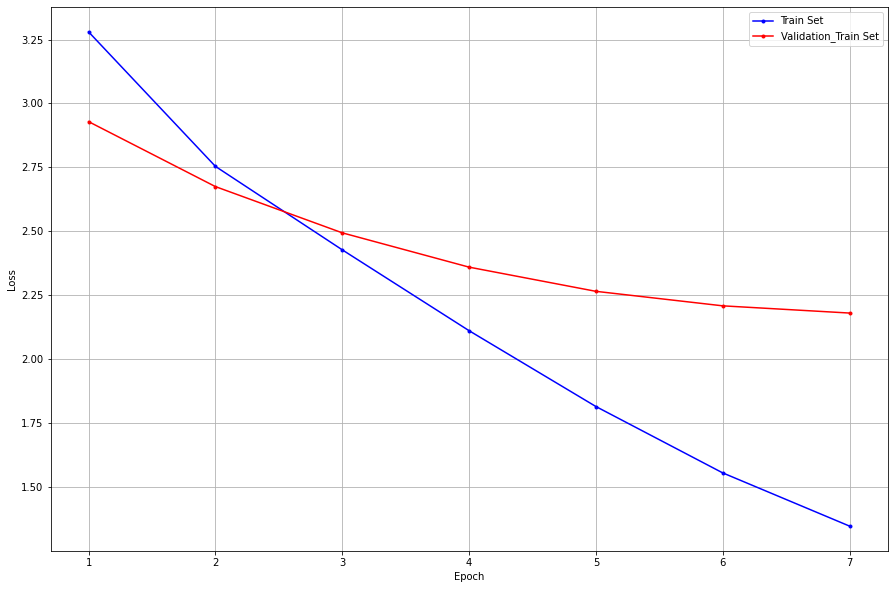

In [34]:
# Train 데이터셋의 학습 결과
loss_train = history.history['loss']
epoch_train = np.arange(len(loss_train)) + 1

loss_test = history.history['val_loss']
epoch_test = np.arange(len(loss_test)) + 1

plt.figure(figsize=(15, 10))
plt.plot(epoch_train, loss_train, c='b', marker='.', label="Train Set")
plt.plot(epoch_test, loss_test, c='r', marker='.', label="Validation_Train Set")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

> Epoch 7에서 validation loss가 2.2 아래로 내려갔다 

In [19]:
history.history['val_loss']

[2.929088592529297,
 2.675299882888794,
 2.4946377277374268,
 2.360614538192749,
 2.266111373901367,
 2.2094337940216064,
 2.1812336444854736]

In [22]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  6000500   
_________________________________________________________________
lstm (LSTM)                  multiple                  20881408  
_________________________________________________________________
lstm_1 (LSTM)                multiple                  33562624  
_________________________________________________________________
dense (Dense)                multiple                  24590049  
Total params: 85,034,581
Trainable params: 85,034,581
Non-trainable params: 0
_________________________________________________________________


# STEP 6. 모델 평가

In [21]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 일단 텐서로 변환합니다.
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 텍스트를 실제로 생성할때는 루프를 돌면서 단어 하나씩 생성해야 합니다. 
    while True:
        predict = model(test_tensor)                                                # 입력받은 문장의 텐서를 입력합니다. 
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   # 우리 모델이 예측한 마지막 단어가 바로 새롭게 생성한 단어가 됩니다. 

        # 우리 모델이 새롭게 예측한 단어를 입력 문장의 뒤에 붙여 줍니다. 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)

        # 우리 모델이 <END>를 예측하지 않았거나, max_len에 도달하지 않았다면  while 루프를 또 돌면서 다음 단어를 예측해야 합니다.
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # 생성된 tensor 안에 있는 word index를 tokenizer.index_word 사전을 통해 실제 단어로 하나씩 변환합니다. 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   # 이것이 최종적으로 모델이 생성한 자연어 문장입니다.

In [27]:
generate_text(model, tokenizer, init_sentence="<start> you", max_len=20)  # 초기값 <start> you를 주어 RNN으로 예측해보기

'<start> you know the stranger is you <end> '

# STEP 7. 회고

1. 이번 프로젝트에서 어려웠던 점 
    - RNN 개념을 이해하는 것이 어려웠습니다
    - 훈련용 데이터와 테스트용 데이터를 분리해서 tf.data.Dataset에 적용하는 방법을 찾는데 어려웠습니다
    - model.fit의 리턴 값에 학습했던 loss 데이터들을 확인할 수 있는 방법을 찾는데 힘들었습니다
2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점
    - dataset 객체 생성하는데 Buffer_size와 Batch가 어떤 식으로 작동되는지 궁금했는데 한 블로그에서 설명해준 내용을 토대로 이해할 수 있었습니다
    - 그런데 이번 프로젝트에서는 tf.data.Dataset으로 생성한 dataset을 활용하지 않았는데 원래 안해도 되는건지 아니면 해야하는데 제가 놓치고 있는건지 모르겠습니다
3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
    - Epoch 5-10 변경하면서 확인
    - Embedding size 100-1000까지 변경
    - Hidden size = 2048까지 변경
    - 정규표현식에서 문장부호 점(.)이 연속으로 나타난 문장을 하나의 점으로 변경
    - 15개 토큰 초과한 문장 제외
    - validation loss 줄이기 위한 하이퍼파라미터 변경
    
4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정  
    - 달성함

    
5. 자기 다짐
     - RNN에 대해서 겉햝기 정도만 알고 있는것 같다. 세부적으로 LSTM과 GRU를 더 정확하게 알아야하고, 다양한 용어에 대해서 이해할 필요가 있다